# Experiment with full training set
In this notebook we analyse the results when the full training set is used. This is the simplest unit of our experiments. This is a subset of the training sets experiment.

In [89]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import shapiro, chi2
from sklearn.linear_model import LinearRegression

ROOTDIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
REPORTDIR = os.path.join(ROOTDIR, "report")
DATADIR = os.path.join(ROOTDIR, "data")
sys.path.insert(0, ROOTDIR)


In [59]:
import glob
from src.data import process

batch1 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-training-sets-*-25.csv"))]
batch2 = [pd.read_csv(frame) for frame in glob.glob(os.path.join(DATADIR, "exp-training-sets-*-25-2.csv"))]

batch1 = pd.concat(batch1)
batch2 = pd.concat(batch2)

# we need to reset the `iteration` column for the second batch
# since we use this column as the index when calculating the
# correlation (see correlation cell below) & we cannot have
# duplicates in this column
batch2["iteration"] = batch2["iteration"] + 25
data = pd.concat([batch1, batch2])
data.shape

(60000, 25)

In [54]:
data.dtypes

model                             object
true_positive_rate_difference    float64
FPR                              float64
FP                               float64
TPR                              float64
privileged                        object
protected                         object
statistical_parity_difference    float64
disparate_impact                 float64
base_rate                        float64
PPV                              float64
TP                               float64
iteration                          int64
FNR                              float64
theil_index                      float64
num_positives                    float64
FN                               float64
f1                               float64
accuracy                         float64
average_abs_odds_difference      float64
TNR                              float64
num_negatives                    float64
dataset_label                     object
TN                               float64
frac            

In [60]:
# preprocessing the data prior to analysis
# 1. fairness metrics are only calculated when privileged == None
# 2. scale fairness metrics according to zhang2021ignorance paper
# 3. combine dataset_label & protected
# 4. set the index to iteration
# 4. drop unused columns
# 4. rename column names
# 4. rename model names
# data = data[data["privileged"] == "None"]
data = data[data["frac"] == 1.0]
process(data)
data["dataset_label"] = data["dataset_label"] + "-" + data["protected"].str.lower()
data = data.rename(columns={
    "dataset_label": "dataset",
    "disparate_impact": "DI",
    "statistical_parity_difference": "SPD",
})
data = data.set_index("iteration")
data = data[[
    "DI",
    "SPD",
    "frac",
    "model",
    "dataset",
    "num_positives",
    "num_negatives",
    "privileged",
]]
data.loc[(data["model"] == "logisticregression"), "model"] = "LR"
data.loc[(data["model"] == "randomforestclassifier"), "model"] = "RF"
data.loc[(data["model"] == "adaboostclassifier"), "model"] = "ADA"
data.loc[(data["model"] == "decisiontreeclassifier"), "model"] = "DT"

data.shape

(6000, 8)

In [61]:
data.dtypes

DI               float64
SPD              float64
frac             float64
model             object
dataset           object
num_positives    float64
num_negatives    float64
privileged        object
dtype: object

## Data validation

In this section I am performing some data quality checks to ensure that the data collection scripts worked as expected.

In [62]:
# here I am checking that we have data for the correct number of sub-subsets of the training set.

data.frac.unique()

array([1.])

In [63]:
# in this cell I am doing some manual checks to make
# sure I am sampling the data correctly by checking
# the shape of the dataset

# each vector should contain num_features*50 points

datasets = data["dataset"].unique().tolist()
models = data["model"].unique().tolist()
models.remove("None")

for dataset in datasets:
    _ = data[
        (data["dataset"] == dataset) &
        (data["model"] == "None") &
        (data["privileged"] == "None")
    ]
    assert _.shape[0] == len(_["frac"].unique().tolist())*50


    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model) &
            (data["privileged"] == "None")
        ]
    assert _.shape[0] == len(_["frac"].unique().tolist())*50

In [70]:
# we should not have any missing values in num_positives & num_negatives when model = None
data[data["model"] == "None"].isna().any()

DI                True
SPD               True
frac             False
model            False
dataset          False
num_positives    False
num_negatives    False
privileged       False
dtype: bool

In [71]:
# we should not have any missing values in DI & SPD when privileged = None
data[data["privileged"] == "None"].isna().any()

DI               False
SPD              False
frac             False
model            False
dataset          False
num_positives     True
num_negatives     True
privileged       False
dtype: bool

# Shapiro-wilk test for normality
In this section we employ the Shapiro-Wilk test for normality. The test is as follows:

- $H_o$: the population is normally distributed
- $H_1$: the population is not normally distributed

We need to test for normality since statistical analysis & formuli used later in the analysis will depend on normality assumption.

In [ ]:
pvalues = {
    "dataset": [],
    "model": [],
    "DI": [],
    "SPD": [],
}

for dataset in datasets:
    _ = data[
        (data["dataset"] == dataset) &
        (data["model"] == "None")
    ]
    pvalues["dataset"].append(dataset)
    pvalues["model"].append("None")
    pvalues["DI"].append(shapiro(_["DI"]).pvalue)
    pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

    for model in models:
        _ = data[
            (data["dataset"] == dataset) &
            (data["model"] == model)
        ]
        pvalues["dataset"].append(dataset)
        pvalues["model"].append(model)
        pvalues["DI"].append(shapiro(_["DI"]).pvalue)
        pvalues["SPD"].append(shapiro(_["SPD"]).pvalue)

pvalues = pd.DataFrame(data=pvalues)
pvalues["DI"] = pvalues["DI"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues["SPD"] = pvalues["SPD"].apply(
    lambda x: "".join(["*" for t in [0.01, 0.05, 0.1] if x<=t])
)
pvalues


,dataset,model,DI,SPD
0,adult-sex,None,,
1,adult-sex,None,,
2,adult-sex,LR,,
3,adult-sex,DT,,
4,adult-sex,ADA,**,
5,adult-sex,RF,,
6,bank-age,None,,
7,bank-age,None,,
8,bank-age,LR,,
9,bank-age,DT,,


# Distributional Analysis
In this section we analyse the distribution of the fairness metrics.

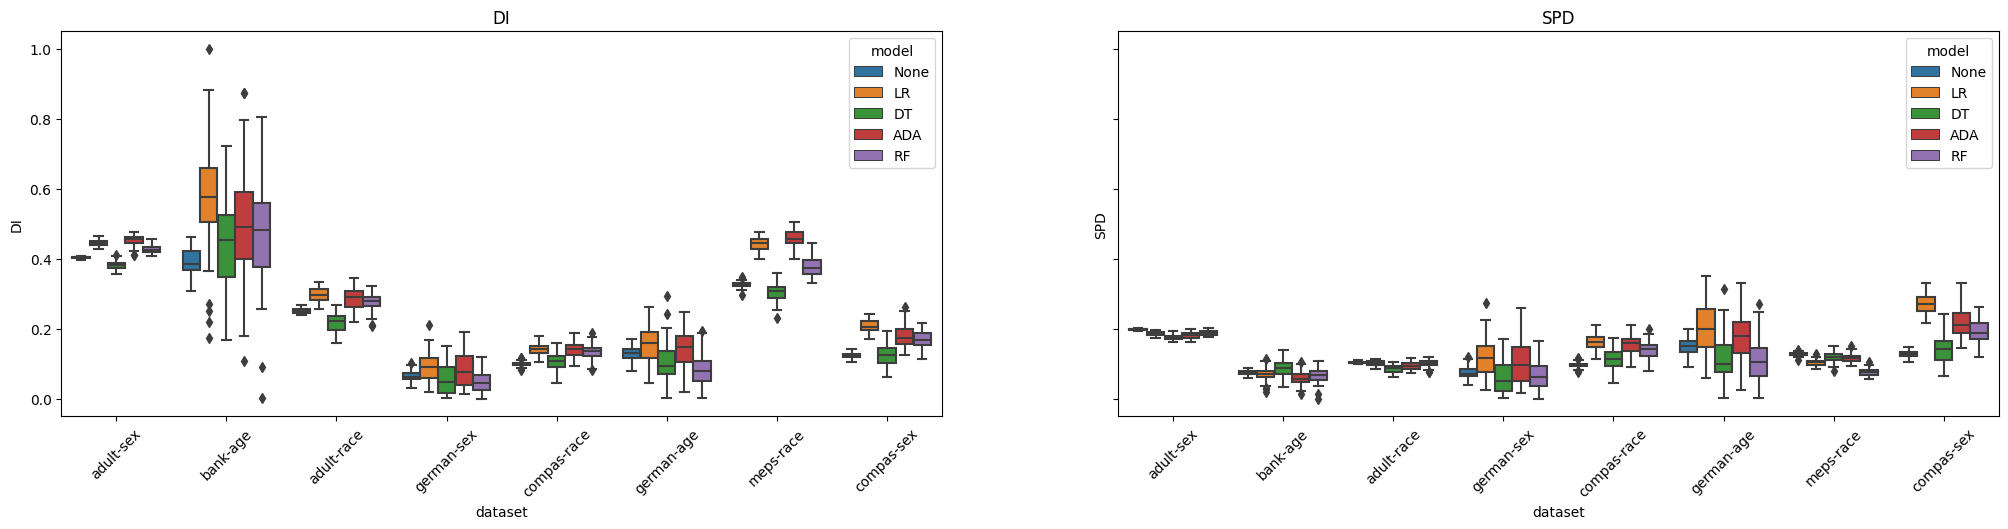

In [90]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(25,5),
    sharey=True,
)

_ = data[data["privileged"] == "None"]
ax = axs[0]
ax.set_title("DI")
ax.tick_params(axis="x", labelrotation=45)
sns.boxplot(
    data=_,
    x="dataset",
    y="DI",
    hue="model",
    ax=ax,
)

ax = axs[1]
ax.set_title("SPD")
ax.tick_params(axis="x", labelrotation=45)
sns.boxplot(
    data=_,
    x="dataset",
    y="SPD",
    hue="model",
    ax=ax,
)

name = "boxplot--dataset--di-spd--exp-full.svg"
fig.savefig(os.path.join(REPORTDIR, name), format="svg")

SPD is sensitive to the number of examples: we see that the variability is low in datasets with more number of examples. I cannot interpret the results for DI though, variability is low in all datasets except for bank-age which is strange because it is not that different from the other dataset?

Lets investigate the distribution of the underlying data in bank-age, see if we can discover something interesting.

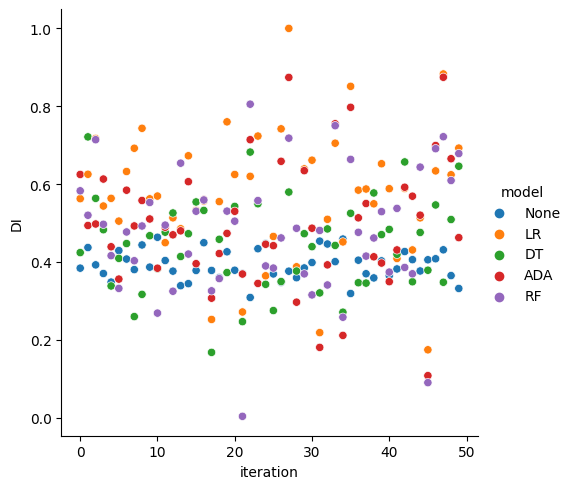

In [103]:
_ = data[
    (data["dataset"] == "bank-age") &
    (data["privileged"] == "None")
]

g = sns.relplot(
    kind="scatter",
    data=_,
    x=_.index,
    y="DI",
    hue="model",
)


<AxesSubplot: title={'center': 'Negative Examples'}, xlabel='dataset', ylabel='num_negatives'>

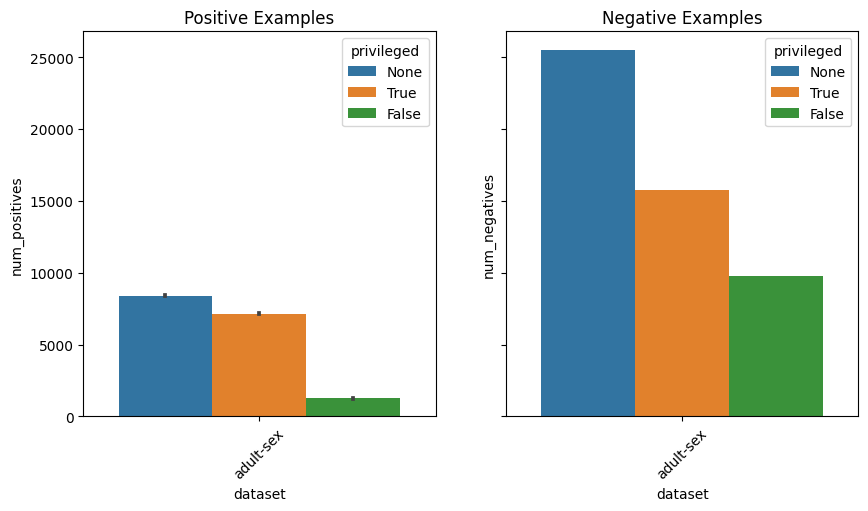

In [87]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10,5),
    sharey=True,
)

_ = data[
    (data["model"] == "None") &
    (data["dataset"] == "adult-sex")
]
ax = axs[0]
ax.set_title("Positive Examples")
ax.tick_params(axis="x", labelrotation=45)
sns.barplot(
    data=_,
    x="dataset",
    y="num_positives",
    hue="privileged",
    ax=ax,
)

ax = axs[1]
ax.set_title("Negative Examples")
ax.tick_params(axis="x", labelrotation=45)
sns.barplot(
    data=_,
    x="dataset",
    y="num_negatives",
    hue="privileged",
    ax=ax,
)

Investigate one outlier in the bank-age dataset to identify why we have so much variability in the results.

In [74]:
_["num_positives"].max()

22291992.967349

<AxesSubplot: xlabel='model', ylabel='value'>

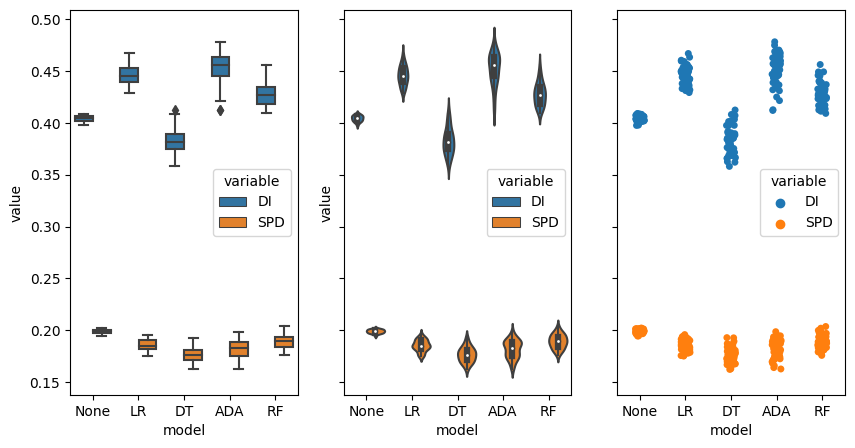

In [7]:
id_vars = ["frac", "model", "dataset"]

_ = data[
    (data["dataset"] == "adult-sex")
]
fig, axs = plt.subplots(
    nrows=1,
    ncols=3,
    sharey=True,
    figsize=(10,5),
)

ax = axs[0]
sns.boxplot(
    data=_.melt(id_vars=id_vars),
    x="model",
    y="value",
    hue="variable",
    ax=ax,
)

ax = axs[1]
sns.violinplot(
    data=_.melt(id_vars=id_vars),
    x="model",
    y="value",
    hue="variable",
    ax=ax,
)

ax = axs[2]
sns.stripplot(
    data=_.melt(id_vars=id_vars),
    x="model",
    y="value",
    hue="variable",
    ax=ax,
)


The data fairness metrics are similar. These seems to be some variation in the model fairness metrics which can be attributed to the randomess in the initial state of the models.

The DFM & MFM convey the same information.

Tree based models (DT & RF) are more fair compared to other models.

We have some outliners which we need to consider when conducting linear regression analysis.

Lets analyse the distribution of the fairness metrics within each frac next.

# Relational analysis
In this section we analyse relationship between our features. In particular:

1. Relationship between DFM MFM

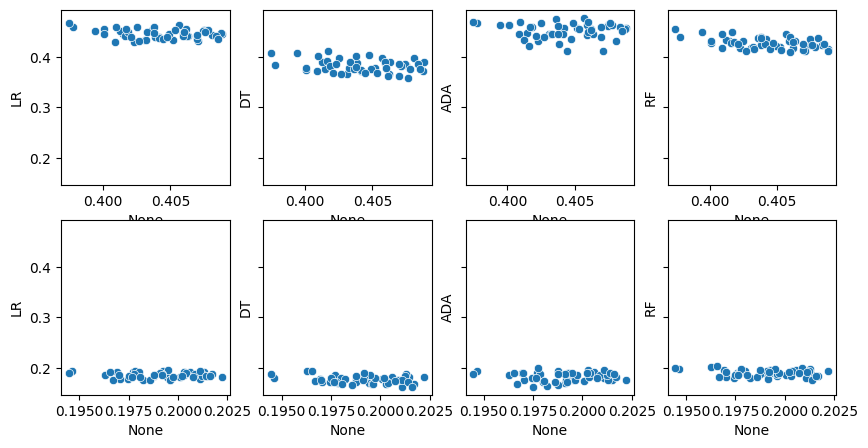

In [8]:
# I want to create scatterplot of DI & SPD of data vs model

fig, axs = plt.subplots(
    nrows=2,
    ncols=4,
    sharey=True,
    figsize=(10, 5),
)

_ = data[data["dataset"] == "adult-sex"]

for row, metric in enumerate(["DI", "SPD"]):
    pivoted = pd.pivot(data=_, columns="model", values=metric,)
    for col, model in enumerate(models):
        ax=axs[row, col]
        ax.set_ylabel(model)
        sns.scatterplot(
            data=pivoted,
            x="None",
            y=model,
            ax=ax,
)

This plot can be a bit misleading. It looks like there is a linear relationship but the y scale is much "wider" compared to the x. We should validate the "fit" using linear regression & analying the residuals.

# Correlation

In [9]:
from scipy.stats import spearmanr

indices = [[
    "DI",
    "SPD",
],
models]
corr = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))
corr_pvalues = pd.DataFrame(columns=datasets, index=pd.MultiIndex.from_product(
    indices, names=["metric", "model"]
))

for d in datasets:
    _ = data[
        (data["dataset"] == d)
    ]
    for metric in ["DI", "SPD"]:
        _pivots = []
        for n in _["frac"].unique().tolist():
            _pivots.append(pd.pivot(
                data=_[_["frac"] == n],
                columns="model",
                values=metric,
            ))
        pivoted = pd.concat(_pivots)
        for model in models:
            c, p = spearmanr(pivoted[model], pivoted["None"])
            corr.loc[(metric, model), d] = c
            corr_pvalues.loc[(metric, model), d] = p

corr

adult-sex  bank-age adult-race german-sex compas-race german-age  \
metric model                                                                    
DI     LR    -0.168788  -0.07611   -0.39006  -0.114384    0.408115  -0.017143   
       DT    -0.196639 -0.158703  -0.576759  -0.026411    0.143145  -0.213504   
       ADA   -0.058151 -0.174166  -0.106363  -0.023818   -0.052293  -0.120243   
       RF    -0.368067 -0.170516   -0.31563  -0.203304    0.170804  -0.120291   
SPD    LR    -0.059304  -0.10982  -0.433565  -0.072799     0.40581  -0.061322   
       DT    -0.146699  -0.19952  -0.538247   -0.03275    0.145834  -0.212159   
       ADA    0.020024   -0.1903  -0.141128   0.013014   -0.092053  -0.131528   
       RF    -0.182041 -0.203938  -0.279232  -0.208202    0.230252  -0.135177   

             meps-race compas-sex  
metric model                       
DI     LR    -0.145642   0.303529  
       DT     -0.32072   0.006963  
       ADA   -0.210276   0.182713  
       RF    -0.186074   0.092437  
SPD    LR    -0.090132   0.372485  
       DT    -0.357791   0.010612  
       ADA   -0.251669   0.141609  
       RF    -0.157839   0.099256

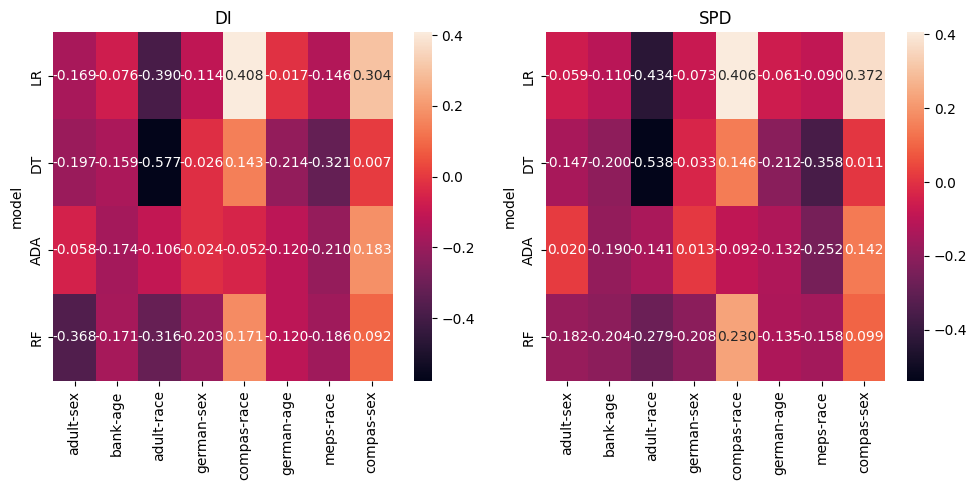

In [10]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5)
)

ax = axs[0]
ax.set_title("DI")
ax.set_ylabel(None)
ax.set_xlabel(None)
sns.heatmap(
    data=corr.loc["DI", :].astype(float),
    annot=True,
    fmt=".3f",
    ax=ax
)

ax = axs[1]
ax.set_title("SPD")
ax.set_ylabel(None)
ax.set_xlabel(None)
sns.heatmap(
    data=corr.loc["SPD", :].astype(float),
    annot=True,
    fmt=".3f",
    ax=ax
)

fig.tight_layout()

In [11]:
corr_pvalues.applymap(
    lambda x: ''.join(['*' for t in [0.01,0.05,0.1] if x<=t])
)

adult-sex bank-age adult-race german-sex compas-race german-age  \
metric model                                                                   
DI     LR                              ***                    ***              
       DT                              ***                                     
       ADA                                                                     
       RF          ***                  **                                     
SPD    LR                              ***                    ***              
       DT                              ***                                     
       ADA                                                                     
       RF                               **                                     

             meps-race compas-sex  
metric model                       
DI     LR                      **  
       DT           **             
       ADA                         
       RF                          
SPD    LR                     ***  
       DT           **             
       ADA           *             
       RF

Do we need more iterations?
`n` depends on the test: more work between 20 - 100
It happens sometimes, we assume it is always going to happen; we always recommend to test in our process

From distribution analysis, we see less variability in DFM than MFM. This is because we only have randomness from the shuffling of data in DFM (no randomness from the model). In the correlation analysis, we are trying to see if we can "predict" or "explain" this variability in the model from the data which is not possible. This is why we see correlation close to 0 in most cases & many are not statistically significant.

**So it does not make sense to present correlation analysis for this experiment.**

But we do have certain cases with strong

In [12]:

d = {
    "dataset": [],
    "model": [],
    "metric": [],
    "x_min": [],
    "x_max": [],
    "x_mean": [],
    "y_min": [],
    "y_max": [],
    "y_mean": [],
    "slope": [],
    "r2": [],
    "f_pvalue": [],
}

for dataset in datasets:
    for model in models:
        for metric in ["DI", "SPD"]:
            x = data[
                (data["dataset"] == dataset) &
                (data["model"] == "None")
            ][metric]
            y = data[
                (data["dataset"] == dataset) &
                (data["model"] == model)
            ][metric]
            mod = sm.OLS(
                endog=y.values.reshape(-1, 1),
                exog=x.values.reshape(-1, 1),
            )
            res = mod.fit()

            d["dataset"].append(dataset)
            d["model"].append(model)
            d["metric"].append(metric)
            d["x_min"].append(x.min())
            d["x_max"].append(x.max())
            d["x_mean"].append(x.mean())
            d["y_min"].append(y.min())
            d["y_max"].append(y.max())
            d["y_mean"].append(y.mean())
            d["slope"].append(res.params[0])
            d["r2"].append(res.rsquared)
            d["f_pvalue"].append(res.f_pvalue)

reg = pd.DataFrame(data=d)
reg


,dataset,model,metric,x_min,x_max,x_mean,y_min,y_max,y_mean,slope,r2,f_pvalue
0,adult-sex,LR,DI,0.397453,0.408841,0.404278,0.429128,0.466777,0.445852,1.102743,0.999461,9.411797e-82
1,adult-sex,LR,SPD,0.194465,0.202224,0.199080,0.175168,0.195872,0.185458,0.931484,0.999039,1.337632e-75
2,adult-sex,DT,DI,0.397453,0.408841,0.404278,0.357979,0.412326,0.382322,0.945582,0.998713,1.750596e-72
3,adult-sex,DT,SPD,0.194465,0.202224,0.199080,0.162320,0.192952,0.176735,0.887609,0.998077,3.234403e-68
4,adult-sex,ADA,DI,0.397453,0.408841,0.404278,0.411875,0.478045,0.452059,1.118117,0.998789,3.872075e-73
...,...,...,...,...,...,...,...,...,...,...,...,...
59,compas-sex,DT,SPD,0.104434,0.148060,0.127702,0.066708,0.242986,0.139986,1.090817,0.927742,1.296880e-29
60,compas-sex,ADA,DI,0.106085,0.141935,0.124598,0.124957,0.262830,0.178241,1.428013,0.969990,5.673325e-39
61,compas-sex,ADA,SPD,0.104434,0.148060,0.127702,0.146627,0.331401,0.216717,1.692442,0.961146,3.192410e-36
62,compas-sex,RF,DI,0.106085,0.141935,0.124598,0.113816,0.217145,0.168066,1.344400,0.976154,2.024870e-41


<AxesSubplot: title={'center': 'SPD'}>

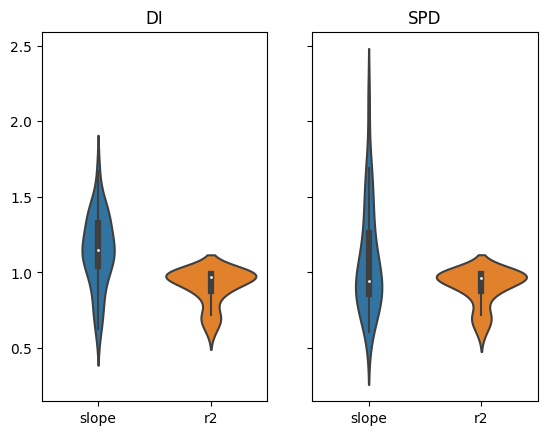

In [13]:
fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
    sharey=True,
)

ax = axs[0]
ax.set_title("DI")
sns.violinplot(
    data=reg.loc[(reg["metric"] == "DI"), ["slope", "r2"]],
    ax=ax,
)

ax = axs[1]
ax.set_title("SPD")
sns.violinplot(
    data=reg.loc[(reg["metric"] == "SPD"), ["slope", "r2"]],
    ax=ax,
)

<AxesSubplot: title={'center': 'Scatterplot of Residuals'}, xlabel='None', ylabel='LR'>

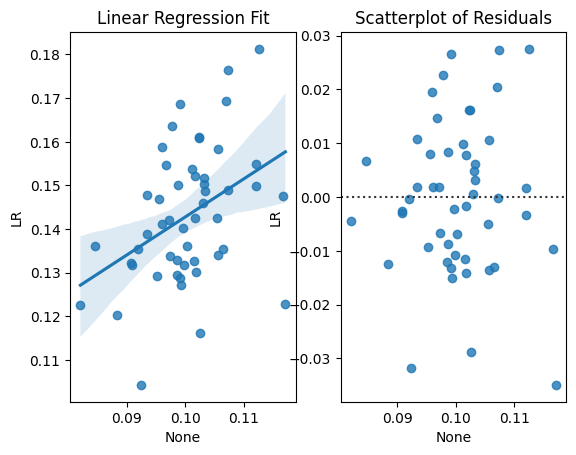

In [43]:
_ = data[data["dataset"] == "compas-race"]
pivoted = pd.pivot(
    data=_,
    columns="model",
    values="DI",
)

fig, axs = plt.subplots(
    nrows=1,
    ncols=2,
)

ax = axs[0]
ax.set_title("Linear Regression Fit")
sns.regplot(
    data=pivoted,
    x="None",
    y="LR",
    scatter=True,
    order=1,
    # robust=True,
    ax=ax,
)

ax = axs[1]
ax.set_title("Scatterplot of Residuals")
sns.residplot(
    data=pivoted,
    x="None",
    y="LR",
    # robust=True,
    order=1,
    ax=ax,
)